<a href="https://colab.research.google.com/github/in7erval/Gesturix/blob/master/research/ClassifySequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime

import numpy as np
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
dataset = 'drive/MyDrive/ClassifySequence/gestures_test_seq_CLEAN.csv'
model_save_path = 'gesture_sequence_classifier_test.hdf5'
LIMIT_LENGTH = 30

# Загрузка и подготовка

загрузим данные

In [ ]:
x, labels = load_data(dataset)
labels[:10], x.shape
# длина координат в каждом из x должна быть кратна 42 (21 точек по икс + 21 точек по игрек)
# формат [x1 y1 x2 y2 x3 y3 ...]

(array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32), (549,))

нормализуем подписи

In [ ]:
NUM_CLASSES = len(set(labels))
min_label = min(labels)
labels_norm = labels.copy()
labels_norm -= min_label
labels_norm[labels_norm == 3] = 2
NUM_CLASSES, labels_norm[:10], set(labels_norm)

(3, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), {0, 1, 2})

Проверка координат (графически и по указательному пальцу)

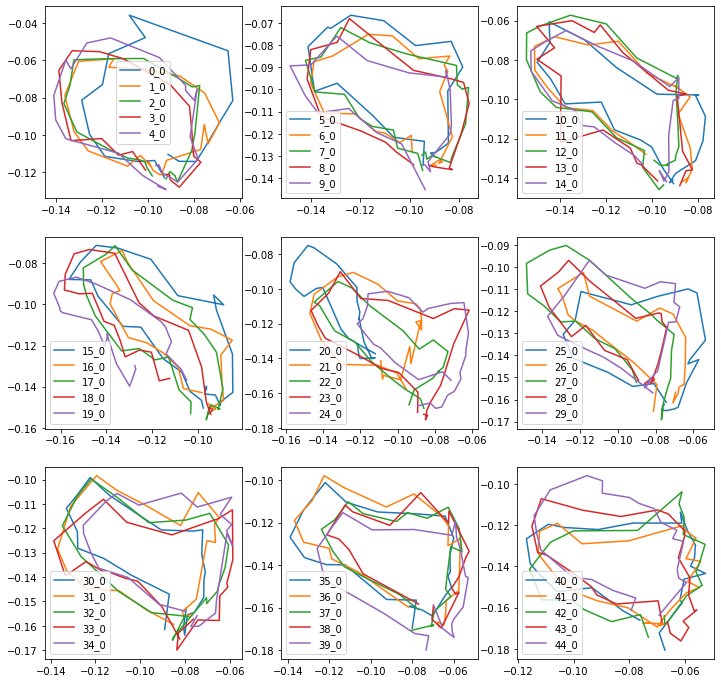

In [ ]:
FROM = 0 #@param ["0", "45", "90", "135", "180", "225", "270", "315", "360"] {type:"raw"}
point_num = 4 #@param {type:"slider", min:0, max:21, step:1}
plot_coords(x, labels_norm, point_num, FROM)

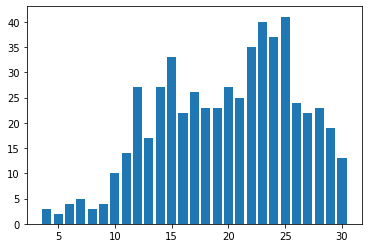

In [ ]:
plot_length(x)

Удаляем последовательности длиннее `LIMIT_LENGHT`


In [ ]:
new_arr_x = []
new_arr_labels_norm = []
indexes = []
for i, x1 in enumerate(x):
  if x1.shape[0] <= LIMIT_LENGTH:
    new_arr_x.append(x1)
    new_arr_labels.append(labels_norm[i])
  else:
    indexes.append(i + 1)
x = np.array(new_arr_x, dtype=object)
labels_norm = np.array(new_arr_labels_norm, dtype='int32')
print(indexes)

[]


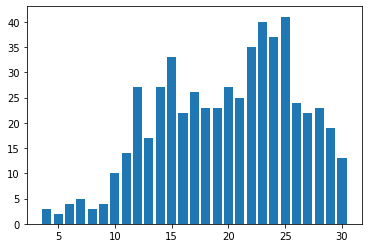

In [ ]:
plot_length(x)

In [ ]:
max_len = max(list(map(lambda x: x.shape[0], x)))
padded_x = sequence.pad_sequences(x, maxlen=max_len, dtype='float', padding='post')
padded_x.shape

(549, 30, 42)

# Пробуем первую модель
> Модель только из LSTM

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_x, labels_norm, test_size=0.25, random_state=42, shuffle=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((411, 30, 42), (138, 30, 42), (411,), (138,))

Оценим сколько где классов

In [ ]:
check_count_classes(Y_train, Y_test)

Train: {0: 39, 1: 40, 2: 41}
Test: {0: 111, 1: 126, 2: 121}


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(X_train[0].shape),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               57200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 57,503
Trainable params: 57,503
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False
)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


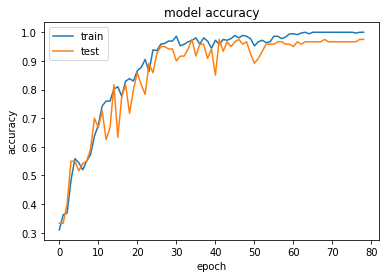

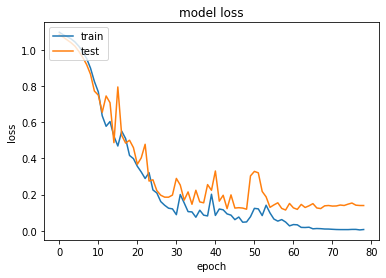

In [ ]:
plot_history(history)

In [ ]:
print(f'{end-begin}')

0:00:23.101145


In [ ]:
val_loss, val_acc = model.evaluate(X_test, Y_test, batch_size=128)

1/1 [==============================] - 0s 44ms/step - loss: 0.1398 - accuracy: 0.9750


In [ ]:
%%time
predict_result = model.predict(np.array([X_test[11]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[6.2994636e-04 1.8225503e-04 9.9918777e-01]
2
CPU times: user 532 ms, sys: 10.3 ms, total: 543 ms
Wall time: 554 ms


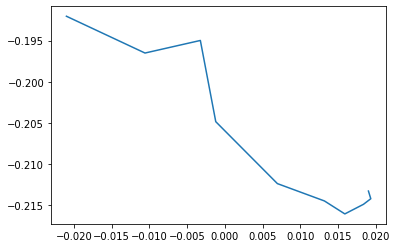

In [ ]:
plt.plot(X_test[11,:10,8], X_test[11,:10,9])

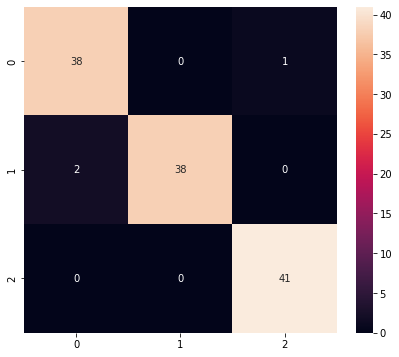

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        39
           1       1.00      0.95      0.97        40
           2       0.98      1.00      0.99        41

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120



In [ ]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print_confusion_matrix(Y_test, y_pred)

In [ ]:
tflite_save_path = 'gestures_sequence_classifier_simple.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpwcmf15rd/assets


INFO:tensorflow:Assets written to: /tmp/tmpwcmf15rd/assets


71040

# Пробуем другую модель
> \+ полносвязный слой перед выходным

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_x, labels_norm, test_size=0.25, random_state=42, shuffle=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((411, 30, 42), (138, 30, 42), (411,), (138,))

Оценим сколько где классов

In [ ]:
check_count_classes(Y_test, Y_train)

Train: {0: 135, 1: 142, 2: 134}
Test: {0: 39, 1: 45, 2: 54}


In [ ]:
model_conv = tf.keras.models.Sequential([
    tf.keras.layers.Input(X_train[0].shape),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_conv.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                18600     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 24,003
Trainable params: 24,003
Non-trainable params: 0
_________________________________________________________________


In [ ]:
begin = datetime.now()
history_conv = model_conv.fit(
    X_train,
    Y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[cp_callback, es_callback]
)
end = datetime.now()

Epoch 1/500
13/13 [==============================] - ETA: 0s - loss: 1.0865 - accuracy: 0.4015
Epoch 1: saving model to gesture_sequence_classifier_test.hdf5
13/13 [==============================] - 3s 64ms/step - loss: 1.0865 - accuracy: 0.4015 - val_loss: 1.0726 - val_accuracy: 0.4928
Epoch 2/500
13/13 [==============================] - ETA: 0s - loss: 1.0604 - accuracy: 0.4939
Epoch 2: saving model to gesture_sequence_classifier_test.hdf5
13/13 [==============================] - 0s 21ms/step - loss: 1.0604 - accuracy: 0.4939 - val_loss: 1.0387 - val_accuracy: 0.5580
Epoch 3/500
13/13 [==============================] - ETA: 0s - loss: 1.0247 - accuracy: 0.5134
Epoch 3: saving model to gesture_sequence_classifier_test.hdf5
13/13 [==============================] - 0s 20ms/step - loss: 1.0247 - accuracy: 0.5134 - val_loss: 0.9673 - val_accuracy: 0.6304
Epoch 4/500
12/13 [==========================>...] - ETA: 0s - loss: 0.9598 - accuracy: 0.5495
Epoch 4: saving model to gesture_sequence

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


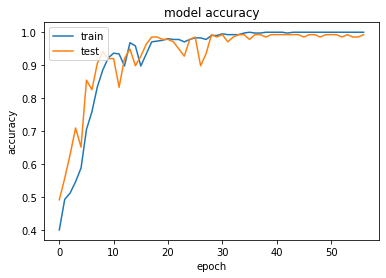

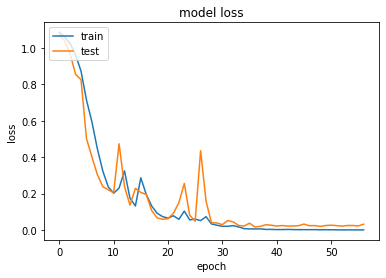

0:00:18.829913


In [ ]:
plot_history(history_conv)
print(f'{end-begin}')

In [ ]:
val_loss, val_acc = model_conv.evaluate(X_test, Y_test, batch_size=128)

2/2 [==============================] - 0s 9ms/step - loss: 0.0322 - accuracy: 0.9928


In [ ]:
%%time
predict_result = model_conv.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[9.9999690e-01 5.2112654e-07 2.6396754e-06]
0
CPU times: user 460 ms, sys: 8.48 ms, total: 469 ms
Wall time: 468 ms


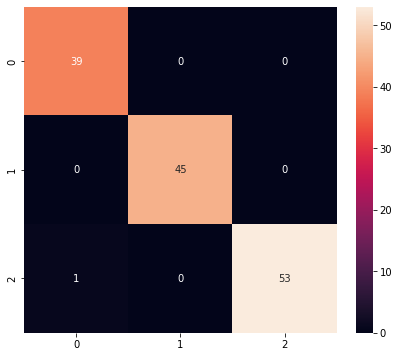

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      1.00      1.00        45
           2       1.00      0.98      0.99        54

    accuracy                           0.99       138
   macro avg       0.99      0.99      0.99       138
weighted avg       0.99      0.99      0.99       138



In [ ]:
Y_pred = model_conv.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print_confusion_matrix(Y_test, y_pred)

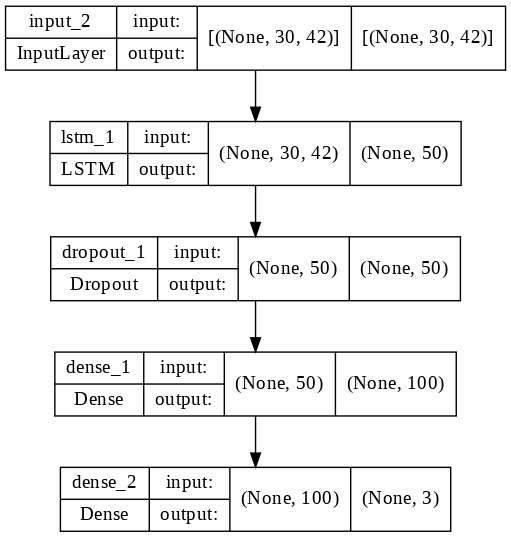

In [ ]:
tf.keras.utils.plot_model(model_conv, 
                          show_shapes=True,
    show_layer_names=True,
    rankdir='TB', # 'TB" or 'LR'
    dpi=100)

In [ ]:
tflite_save_path = 'gestures_sequence_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model_conv)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpoluqd59z/assets


INFO:tensorflow:Assets written to: /tmp/tmpoluqd59z/assets


36944

In [ ]:
tflite_save_path = 'gestures_sequence_classifier.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details, output_details
input_len = input_details[0]['shape'][1]
test_data = 'gestures_test_seq_ch.csv'
x, labels = load_data(test_data, sep=' | ')
labels[:10], x.shape

(array([1, 1, 2, 2, 2, 2, 2, 3, 3, 3], dtype=int32), (21,))

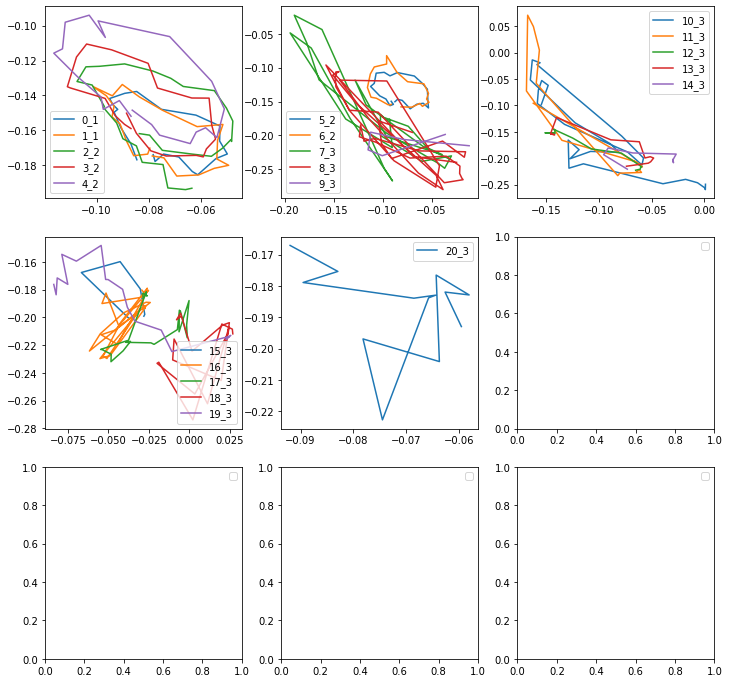

In [ ]:
FROM = 0 #@param ["0", "45", "90", "135", "180", "225", "270", "315", "360"] {type:"raw"}
point_num = 4 #@param {type:"slider", min:0, max:21, step:1}
plot_coords(x, labels, point_num, FROM)

In [ ]:
padded_x = sequence.pad_sequences(x, maxlen=input_len, dtype='float', padding='post')
padded_x.shape

(21, 30, 42)

In [ ]:
%%time
interpreter.set_tensor(input_details[0]['index'], np.array([padded_x[3]], dtype='float32'))
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.5071836e-06 9.9999273e-01 4.7807907e-06]
1
CPU times: user 7.89 ms, sys: 0 ns, total: 7.89 ms
Wall time: 20.9 ms


# Util Funcs

In [ ]:
def plot_history(history):
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(Y_test, y_pred))

In [ ]:
def plot_coords(x, labels, point_num: int, num_from, delta=45):
  to = num_from + delta
  ranges = [range(a, min((a + 5), len(labels))) for a in range(num_from, to, 5)]
  subplots_nums = [331, 332, 333, 334, 335, 336, 337, 338, 339]
  tips_x = []
  tips_y = []
  for a in x:
    finger_tip_coords_x = list(map(lambda x: x[point_num * 2], a))
    finger_tip_coords_y = list(map(lambda x: x[point_num * 2 + 1], a))
    tips_x.append(finger_tip_coords_x)
    tips_y.append(finger_tip_coords_y)

  plt.figure(figsize=(12, 12))
  for rng, subplot_num in zip(ranges, subplots_nums):
    plt.subplot(subplot_num)
    for i in rng:
      if len(tips_x) > i:
        plt.plot(tips_x[i], tips_y[i])
    plt.legend([f'{i}_{labels[i]}' for i in rng], loc='best')
  plt.show()


In [ ]:
def get_length_str(x):
  lengths_dict = {}
  lengths_list = list(map(lambda x: x.shape[0], x))
  for length in lengths_list:
    if length in lengths_dict.keys():
      lengths_dict[length] += 1
    else:
      lengths_dict[length] = 1
  max_len = max(list(map(lambda x: x.shape[0], x)))
  lengths_list = [(k, v) for k, v in lengths_dict.items()]
  lengths_list.sort(key=lambda x: x[0], reverse=True)
  lengths_str_list = [f'{i[0]}: {i[1]}' for i in lengths_list]
  str_out = 'Length: count\n' + "\n".join(lengths_str_list)
  return f'Max_length: {max_len}\n{str_out}'

In [ ]:
def check_count_classes(Y_test, Y_train):
  unique_train, counts_train = np.unique(Y_train, return_counts=True)
  unique_test, counts_test = np.unique(Y_test, return_counts=True)

  print('Train:', dict(zip(unique_train, counts_train)))
  print('Test:', dict(zip(unique_test, counts_test)))

In [ ]:
def load_data(fname: str, normalize: bool=True, sep: str = ';'):
  x = []
  labels = []
  with open(fname) as f:
      lines = f.readlines()
      for line in lines:
          spl = line.split(sep)
          labels.append(int(spl[0][:-1]))
          filtered_list = list(filter(lambda x: x and len(x.strip()) != 0, spl[1:]))
          coords_seq = np.array(
              list(
                map(
                  lambda x: np.array(x), 
                  map(eval, filtered_list)
                )
              )
          )
          if normalize:
            for coords in coords_seq:
              first_x = coords[0]
              first_y = coords[1]
              coords[0::2] -= first_x
              coords[1::2] -= first_y
          x.append(coords_seq)
  x = np.array(x, dtype='object')
  labels = np.array(labels, dtype='int32')
  return x, labels


In [ ]:
def plot_length(x):
  lengths_dict = {}
  lengths_list = list(map(lambda x: x.shape[0], x))
  for length in lengths_list:
    if length in lengths_dict.keys():
      lengths_dict[length] += 1
    else:
      lengths_dict[length] = 1
  max_len = max(list(map(lambda x: x.shape[0], x)))
  xs = []
  ys = []
  for k, v in lengths_dict.items():
    xs.append(k)
    ys.append(v)
  plt.bar(xs, ys)